<a href="https://colab.research.google.com/github/Joboreh97/Codes-that-function/blob/main/tutorials/phy/functionalstyle_phasenoise0.1stddev_aware_64unit_pruned_demapper_architecture_neu_model_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Learning with Autoencoders

In this notebook, you will learn how to implement an end-to-end communication system as an autoencoder [1].
The implemented system is shown in the figure below.
An additive white Gaussian noise (AWGN) channel is considered.
On the transmitter side, joint training of the constellation geometry and bit-labeling is performed, as in [2].
On the receiver side, a neural network-based demapper that computes log-likelihood ratios (LLRs) on the transmitted bits from the received samples is optimized.
The considered autoencoder is benchmarked against a quadrature amplitude modulation (QAM) with Gray labeling and the optimal AWGN demapper.

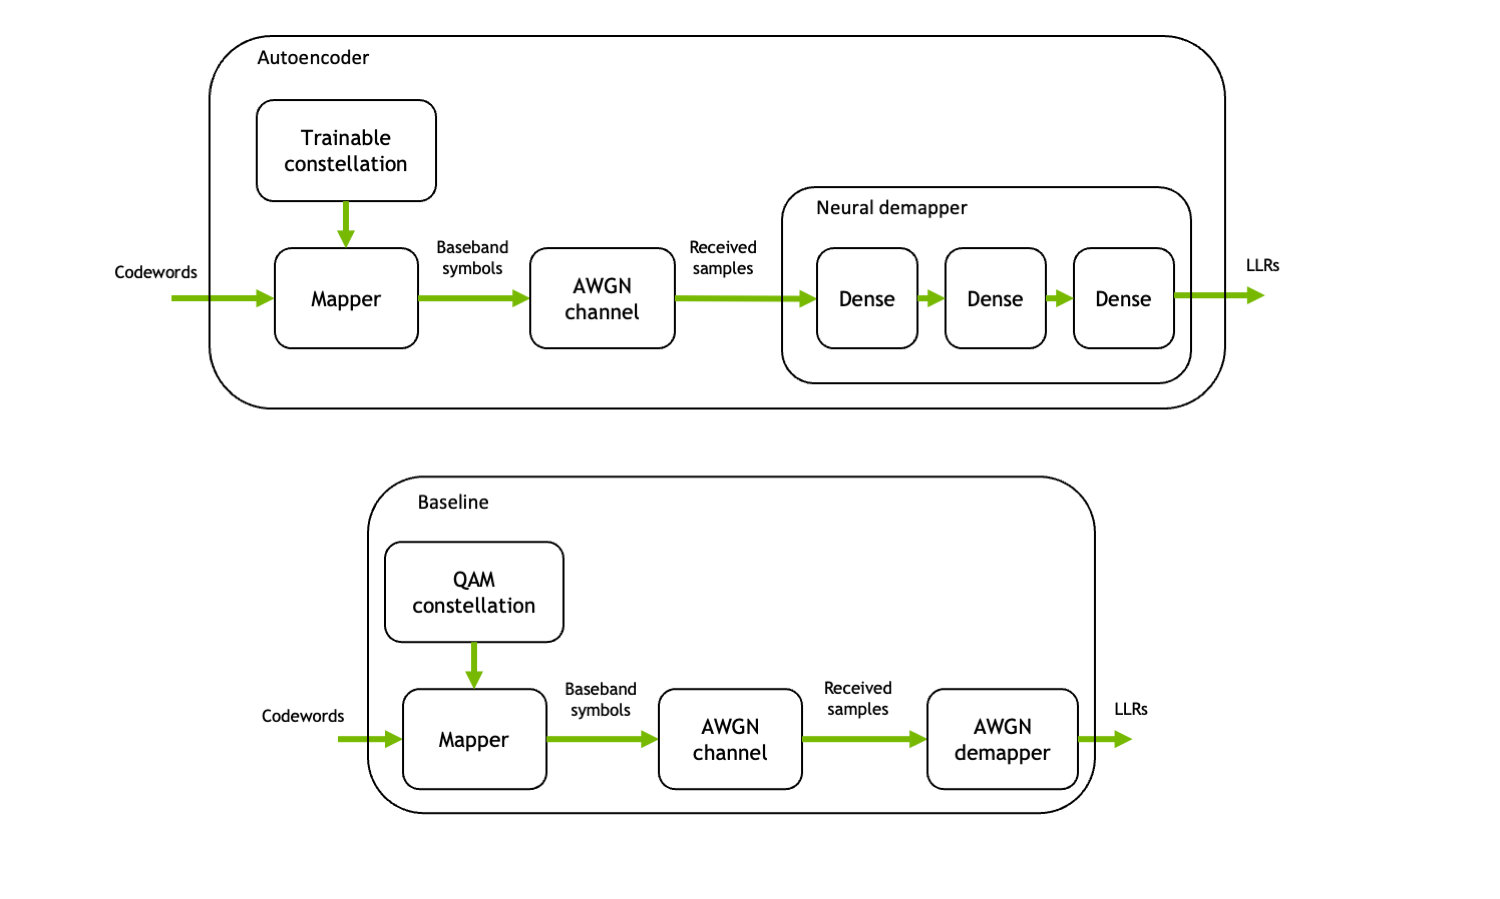


Two algorithms for training the autoencoder are implemented in this notebook:

* Conventional stochastic gradient descent (SGD) with backpropagation, which assumes a differentiable channel model and therefore optimizes the end-to-end system by backpropagating the gradients through the channel (see, e.g., [1]).
* The training algorithm from [3], which does not assume a differentiable channel model, and which trains the end-to-end system by alternating between conventional training of the receiver and reinforcement learning (RL)-based training of the transmitter. Compared to [3], an additional step of fine-tuning of the receiver is performed after alternating training.

**Note:** For an introduction to the implementation of differentiable communication systems and their optimization through SGD and backpropagation with Sionna, please refer to [the Part 2 of the Sionna tutorial for Beginners](https://nvlabs.github.io/sionna/phy/tutorials/Sionna_tutorial_part2.html).

* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Simulation Parameters](#Simulation-Parameters)
* [Neural Demapper](#Neural-Demapper)
* [Trainable End-to-end System: Conventional Training](#Trainable-End-to-end-System:-Conventional-Training)
* [Trainable End-to-end System: RL-based Training](#Trainable-End-to-end-System:-RL-based-Training)
* [Evaluation](#Evaluation)
* [Visualizing the Learned Constellations](#Visualizing-the-Learned-Constellations)
* [References](#References)

## GPU Configuration and Imports

In [1]:
!pip show tensorflow
!pip show tf_keras

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, sionna, tensorflow-text, tensorflow_decision_forests, tf_keras
Name: tf_keras
Version: 2.18.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: tensorflow
Required-by: dopamine_rl, tensorflow-hub, tensorflow_decision_forests


In [2]:
# ✅ Set this before importing TensorFlow to use legacy tf.keras (Keras 2)
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

# Optional: Set GPU and logging behavior
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0  # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Add this to disable XNNPACK delegate for TFLite interpreter:
os.environ["TFLITE_ENABLE_XNNPACK"] = "0"
os.environ["TFLITE_DISABLE_SELECT_TF_OPS"] = "1"     # Add this
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"            # Add this too
# ✅ Now import TensorFlow and confirm it's using legacy Keras
import tensorflow as tf
import tf_keras
print("Legacy tf_keras version:", tf_keras.__version__)  # Should print 2.18.0

# ✅ Sionna setup
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
        print("Installing Sionna and restarting the runtime. Please run the cell again.")
        os.system("pip install sionna")
        os.kill(os.getpid(), 5)
    else:
        raise e

# ✅ GPU setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# ✅ Suppress warnings from TF logger
tf.get_logger().setLevel('ERROR')

# ✅ Imports from tf.keras instead of standalone keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense

# ✅ Sionna imports
from sionna.phy import Block
from sionna.phy.channel import AWGN
from sionna.phy.utils import ebnodb2no, log10, expand_to_rank
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.mapping import Mapper, Demapper, Constellation, BinarySource
from sionna.phy.utils import sim_ber

# ✅ Seed
sionna.phy.config.seed = 42

# ✅ Jupyter/plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle


Legacy tf_keras version: 2.18.0


In [3]:
!pip install tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 8.2 MB/s eta 0:00:00


# Simulation Parameter

In [4]:
###############################################
# SNR range for evaluation and training [dB]
###############################################
ebno_db_min = 4.0
ebno_db_max = 8.0

###############################################
# Modulation and coding configuration
###############################################
num_bits_per_symbol = 6 # Baseline is 64-QAM
modulation_order = 2**num_bits_per_symbol
coderate = 0.5 # Coderate for the outer code
n = 1500 # Codeword length [bit]. Must be a multiple of num_bits_per_symbol
num_symbols_per_codeword = n//num_bits_per_symbol # Number of modulated baseband symbols per codeword
k = int(n*coderate) # Number of information bits per codeword

###############################################
# Training configuration
###############################################
num_training_iterations_conventional = 1000 # Number of training iterations for conventional training
# Number of training iterations with RL-based training for the alternating training phase and fine-tuning of the receiver phase
num_training_iterations_rl_alt = 700
num_training_iterations_rl_finetuning = 300
training_batch_size = tf.constant(128, tf.int32) # Training batch size
rl_perturbation_var = 0.01 # Variance of the perturbation used for RL-based training of the transmitter
model_weights_path_conventional_training = "awgn_autoencoder_weights_conventional_training" # Filename to save the autoencoder weights once conventional training is done
model_weights_path_conventional_training_pruned = "awgn_autoencoder_weights_conventional_training_pruned" # Filename to save the autoencoder weights once conventional training is done
model_weights_path_qat = "awgn_autoencoder_weights_qat" # Filename to save the autoencoder weights once QAT is done
model_weights_path_quantized_conventional_training = "awgn_autoencoder_quantized_weights_conventional_training"
model_weights_path_rl_training = "awgn_autoencoder_weights_rl_training" # Filename to save the autoencoder weights once RL-based training is done

###############################################
# Evaluation configuration
###############################################
results_filename = "awgn_autoencoder_results" # Location to save the results

# Neural Demapper

The neural network-based demapper shown in the figure above is made of three dense layers with ReLU activation.

The input of the demapper consists of a received sample $y \in \mathbb{C}$ and the noise power spectral density $N_0$ in log-10 scale to handle different orders of magnitude for the SNR.

As the neural network can only process real-valued inputs, these values are fed as a 3-dimensional vector

$$\left[ \mathcal{R}(y), \mathcal{I}(y), \log_{10}(N_0) \right]$$

where $\mathcal{R}(y)$ and $\mathcal{I}(y)$ refer to the real and imaginary component of $y$, respectively.

The output of the neural network-based demapper consists of LLRs on the `num_bits_per_symbol` bits mapped to a constellation point. Therefore, the last layer consists of ``num_bits_per_symbol`` units.

**Note**: The neural network-based demapper processes the received samples $y$ forming a block individually. The [neural receiver notebook](https://nvlabs.github.io/sionna/phy/tutorials/Neural_Receiver.html) provides an example of a more advanced neural network-based receiver that jointly processes a resource grid of received symbols.

**Neural Demapper for AWGN Channel**

In [5]:
def preprocess_complex_input(y, no, num_symbols_per_codeword):
    def log10_fn(x):
        return tf.math.log(x) / tf.math.log(tf.constant(10, dtype=tf.float32))

    no_db = log10_fn(no)  # shape: [batch_size, 1]
    re = tf.math.real(y)  # shape: [batch_size, num_symbols_per_codeword]
    im = tf.math.imag(y)

    # Broadcast no_db to match shape of re: [batch_size, num_symbols_per_codeword]
    no_db = tf.broadcast_to(no_db, tf.shape(re))

    # Stack into shape: [batch_size, num_symbols_per_codeword, 3]
    z = tf.stack([re, im, no_db], axis=-1)
    return z

In [6]:
from tensorflow.keras.layers import Input, Dense

def create_functional_demapper_real_input(num_symbols_per_codeword, num_bits_per_symbol):
    z_input = Input(shape=(num_symbols_per_codeword, 3), dtype=tf.float32, name="z_input")
    x = Dense(128, activation="relu")(z_input)
    x = Dense(128, activation="relu")(x)
    llr = Dense(num_bits_per_symbol)(x)
    return Model(inputs=z_input, outputs=llr, name="FunctionalDemapperReal")



In [7]:
import tensorflow_model_optimization as tfmot

# Float32 demapper
float_demapper = create_functional_demapper_real_input(
    num_symbols_per_codeword, num_bits_per_symbol)

# QAT wrapper
qat_demapper_model = tfmot.quantization.keras.quantize_model(float_demapper)



**Neural Demapper for (Phase Noise + AWGN) Channel**

In [8]:
import tensorflow as tf
from sionna.phy.utils import log10

def preprocess_complex_phase_noise_input(y, no, sigma_phi, num_symbols_per_codeword):
    """
    Preprocess inputs for the phase noise demapper *without* internal preprocessing.
    """
    def log10_fn(x):
        return tf.math.log(x) / tf.math.log(tf.constant(10, dtype=tf.float32))

    batch_size = tf.shape(y)[0]
    no = tf.convert_to_tensor(no, dtype=tf.float32)
    sigma_phi = tf.convert_to_tensor(sigma_phi, dtype=tf.float32)
    no = tf.reshape(no, [-1, 1]) if len(no.shape) < 2 else no
    sigma_phi = tf.reshape(sigma_phi, [-1, 1]) if len(sigma_phi.shape) < 2 else sigma_phi
    no_db = log10_fn(no)
    no_db_tiled = tf.tile(no_db, [1, num_symbols_per_codeword])
    sigma_phi_tiled = tf.tile(sigma_phi, [1, num_symbols_per_codeword])
    z = tf.stack([
        tf.math.real(y),
        tf.math.imag(y),
        no_db_tiled,
        sigma_phi_tiled
    ], axis=2)
    return z

In [9]:
def create_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True):
    z_input = Input(shape=(250, 4), dtype=tf.float32, name="z_input")
    x = Dense(512, activation='relu', name='dense1')(z_input)
    x = Dense(512, activation='relu', name='dense2')(x)
    x = Dense(512, activation='relu', name='dense3')(x)
    output_units = num_bits_per_symbol if bitwise else 2**num_bits_per_symbol
    llr = Dense(output_units, activation=None, name='dense_out')(x)
    model = Model(inputs=z_input, outputs=llr, name="FunctionalDemapperPhaseNoise")
    return model

import tensorflow_model_optimization as tfmot

In [10]:
float_demapper_phase_noise = create_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol,bitwise=True)

**Demapper Prunning**

In [11]:
pruning_params = {
    "initial_sparsity": 0.0,
    "final_sparsity": 0.875,
    "begin_step": 0,
    "end_step": 1000,
}

In [12]:
def create_pruned_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, pruning_params, bitwise=True):
    pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=pruning_params["initial_sparsity"],
        final_sparsity=pruning_params["final_sparsity"],
        begin_step=pruning_params["begin_step"],
        end_step=pruning_params["end_step"],
    )
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    z_input = Input(shape=(250, 4), dtype=tf.float32, name="z_input")
    x = prune_low_magnitude(Dense(512, activation='relu', name='pruned_dense1'), pruning_schedule=pruning_schedule)(z_input)
    x = prune_low_magnitude(Dense(512, activation='relu', name='pruned_dense2'), pruning_schedule=pruning_schedule)(x)
    x = prune_low_magnitude(Dense(512, activation='relu', name='pruned_dense3'), pruning_schedule=pruning_schedule)(x)
    output_units = num_bits_per_symbol if bitwise else 2**num_bits_per_symbol
    llr = prune_low_magnitude(Dense(output_units, activation=None, name='pruned_dense_out'), pruning_schedule=pruning_schedule)(x)
    model = Model(inputs=z_input, outputs=llr, name="PrunedFunctionalDemapperPhaseNoise")
    return model

**Phase Noise**

In [13]:
class PhaseNoise(Block):
    def __init__(self, *, precision=None, **kwargs):
        super().__init__(precision=precision, **kwargs)

    def call(self, x, sigma):
        phi = tf.random.normal(
            shape=tf.shape(x),
            mean=0.0,
            stddev=1.0,
            dtype=self.rdtype
        )
        sigma = expand_to_rank(sigma, tf.rank(x), axis=-1)
        sigma = tf.cast(sigma, self.rdtype)
        phi *= sigma
        phase_rotation = tf.complex(tf.math.cos(phi), tf.math.sin(phi))
        return x * phase_rotation


**Phase Noise Gaussian**

In [14]:
class PhaseNoiseGaussian(tf.keras.layers.Layer):
    def __init__(self, dtype=tf.complex64, name="phase_noise_gaussian", **kwargs):
        super().__init__(dtype=dtype, name=name, **kwargs)
        self._real_dtype = tf.dtypes.as_dtype(self._dtype).real_dtype
        self.start_phase_init = -1*np.pi
        self.start_phase_width = np.pi

    def call(self, inputs):
        print('*********Inside Gaussian Distributed PN************')
        x, sigma_phi = inputs
        var = 1.0
        var_dim = tf.cast(var, x.dtype.real_dtype)/tf.cast(2, x.dtype.real_dtype)
        stddev = tf.sqrt(var_dim)
        noise = tf.random.normal(tf.shape(x), mean=0.0, stddev=stddev, dtype=x.dtype.real_dtype)
        sigma_phi = expand_to_rank(sigma_phi, tf.rank(x), axis=-1)
        sigma_phi = tf.cast(sigma_phi, self._real_dtype)
        noise *= tf.cast(sigma_phi, noise.dtype)
        pnr = tf.math.cos(noise)
        pni = tf.math.sin(noise)
        pn = tf.complex(pnr,pni)
        return x*pn

## Trainable End-to-end System: Conventional Training

The following cell defines an end-to-end communication system that transmits bits modulated using a trainable constellation over an AWGN channel.

The receiver uses the previously defined neural network-based demapper to compute LLRs on the transmitted (coded) bits.

As in [1], the constellation and neural network-based demapper are jointly trained through SGD and backpropagation using the binary cross entropy (BCE) as loss function.

Training on the BCE is known to be equivalent to maximizing an achievable information rate [2].

The following model can be instantiated either for training (`training = True`) or evaluation (`training = False`).

In the former case, the BCE is returned and no outer code is used to reduce computational complexity and as it does not impact the training of the constellation or demapper.

When setting `training` to `False`, an LDPC outer code from 5G NR is applied.

In [15]:
# class E2EDataGenerator(tf.keras.utils.Sequence):
#     def __init__(self, num_batches, batch_size, ebno_db_min, ebno_db_max):
#         self.num_batches = num_batches
#         self.batch_size = batch_size
#         self.ebno_db_min = ebno_db_min
#         self.ebno_db_max = ebno_db_max

#     def __len__(self):
#         return self.num_batches

#     def __getitem__(self, idx):
#         ebno_db = tf.random.uniform(
#             shape=[self.batch_size],
#             minval=self.ebno_db_min,
#             maxval=self.ebno_db_max
#         )
#         # Dummy input (could be zeros, not used in your call)
#         x = tf.zeros([self.batch_size, 1])
#         # The model will ignore x and generate its own data internally
#         # We pass ebno_db as y, since your model expects (batch_size, ebno_db)
#         return x, ebno_db


In [16]:
# def gen():
#     for _ in range(num_training_iterations_conventional):
#         ebno_db = tf.random.uniform(
#             shape=[training_batch_size],
#             minval=ebno_db_min,
#             maxval=ebno_db_max
#         )
#         x = tf.zeros([training_batch_size, 1])
#         yield x, ebno_db

# data_gen = tf.data.Dataset.from_generator(
#     gen,
#     output_signature=(
#         tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
#         tf.TensorSpec(shape=(None,), dtype=tf.float32)
#     )
# )


In [17]:
import tensorflow as tf

class DynamicBinarySource(tf.keras.layers.Layer):
    """Custom binary source layer supporting dynamic batch sizes"""
    def __init__(self, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)

    def call(self, shape):
        # shape: Tensor containing [batch_size, num_bits]
        u = tf.random.uniform(shape, minval=0, maxval=1, dtype=self.dtype)
        return tf.where(u < 0.5, 0.0, 1.0)

In [18]:
class E2ESystemConventionalTraining(tf.keras.Model):
    def __init__(self, training, use_pruning=False, pruning_params=None, pretrained_weights_path=None, name="e2e_system"):
        super().__init__(name=name)
        self._training = training
        self._use_pruning = use_pruning

        # Transmitter - Use custom binary source
        self._binary_source = DynamicBinarySource(dtype=tf.float32)
        if not self._training:
            self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)

        qam_points = Constellation("qam", num_bits_per_symbol).points
        initial_points_r = tf.math.real(qam_points)
        initial_points_i = tf.math.imag(qam_points)

        self.points_r = self.add_weight(name='points_r', shape=initial_points_r.shape, initializer="zeros")
        self.points_i = self.add_weight(name='points_i', shape=initial_points_i.shape, initializer="zeros")
        self.points_r.assign(initial_points_r)
        self.points_i.assign(initial_points_i)

        points = tf.complex(self.points_r, self.points_i)
        self.constellation = Constellation("custom", num_bits_per_symbol, points=points, normalize=True, center=True)
        self._mapper = Mapper(constellation=self.constellation)

        # Channel
        self._phase_noise = PhaseNoiseGaussian(name="phase_noise")
        self._channel = AWGN()

        # Receiver
        if self._use_pruning and pruning_params:
            self._demapper = create_pruned_functional_demapper_phase_noise_from_preprocessed(
                num_bits_per_symbol, pruning_params, bitwise=True)
        else:
            self._demapper = create_functional_demapper_phase_noise_from_preprocessed(
                num_bits_per_symbol, bitwise=True)

        if not self._training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

        if self._training:
            self._bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def call(self, inputs, training=False):
        x, ebno_db = inputs
        batch_size = tf.shape(x)[0]  # Get dynamic batch size as tensor

        points = tf.complex(self.points_r, self.points_i)
        self.constellation.points = points

        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)

        # Use dynamic batch size with custom binary source
        if self._training:
            # Create shape tensor [batch_size, n]
            shape = tf.stack([batch_size, n])
            c = self._binary_source(shape)
        else:
            shape = tf.stack([batch_size, k])
            b = self._binary_source(shape)
            c = self._encoder(b)

        x = self._mapper(c)
        sigma_phi = tf.fill([batch_size, 1], 0.1)
        x_phase_noisy = self._phase_noise((x, sigma_phi))
        y = self._channel(x_phase_noisy, no)
        z = preprocess_complex_phase_noise_input(y, no, sigma_phi, num_symbols_per_codeword)
        llr = self._demapper(z)
        if self._training:
            c_reshaped = tf.reshape(c, [batch_size, num_symbols_per_codeword, num_bits_per_symbol])
            loss = self._bce(c_reshaped, llr)
            return loss
        else:
            llr_reshaped = tf.reshape(llr, [batch_size, n])
            b_hat = self._decoder(llr_reshaped)
            return b, b_hat

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self(data, training=True)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        return {"loss": loss}

In [19]:
# class E2ESystemConventionalTraining(tf.keras.Model):
#     def __init__(self, training, use_pruning=False, pruning_params=None, pretrained_weights_path=None, name="e2e_system"):
#         super().__init__(name=name)
#         self._training = training
#         self._use_pruning = use_pruning
#         batch_size = 128
#         # Transmitter
#         self._binary_source = BinarySource()
#         if not self._training:
#             self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)

#         qam_points = Constellation("qam", num_bits_per_symbol).points
#         initial_points_r = tf.math.real(qam_points)
#         initial_points_i = tf.math.imag(qam_points)

#         self.points_r = self.add_weight(name='points_r', shape=initial_points_r.shape, initializer="zeros")
#         self.points_i = self.add_weight(name='points_i', shape=initial_points_i.shape, initializer="zeros")
#         self.points_r.assign(initial_points_r)
#         self.points_i.assign(initial_points_i)

#         points = tf.complex(self.points_r, self.points_i)
#         self.constellation = Constellation("custom", num_bits_per_symbol, points=points, normalize=True, center=True)
#         self._mapper = Mapper(constellation=self.constellation)

#         # Channel
#         self._phase_noise = PhaseNoiseGaussian(name="phase_noise")
#         self._channel = AWGN()

#         # Receiver
#         if self._use_pruning and pruning_params:
#             self._demapper = create_pruned_functional_demapper_phase_noise_from_preprocessed(
#                 num_bits_per_symbol, pruning_params, bitwise=True)
#         else:
#             self._demapper = create_functional_demapper_phase_noise_from_preprocessed(
#                 num_bits_per_symbol, bitwise=True)

#         if not self._training:
#             self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

#         if self._training:
#             self._bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#     def call(self, inputs,training=False):
#         x, ebno_db = inputs
#         batch_size = x.shape[0]
#         points = tf.complex(self.points_r, self.points_i)
#         self.constellation.points = points

#         no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
#         no = expand_to_rank(no, 2)
#         if self._training:

#             c = self._binary_source([batch_size, n])
#         else:
#             b = self._binary_source([batch_size, k])
#             c = self._encoder(b)
#         x = self._mapper(c)
#         sigma_phi = tf.fill([batch_size, 1], 0.1)
#         x_phase_noisy = self._phase_noise((x, sigma_phi))
#         y = self._channel(x_phase_noisy, no)
#         z = preprocess_complex_phase_noise_input(y, no, sigma_phi, num_symbols_per_codeword)
#         llr = self._demapper(z)
#         if self._training:
#             c_reshaped = tf.reshape(c, [batch_size, num_symbols_per_codeword, num_bits_per_symbol])
#             loss = self._bce(c_reshaped, llr)
#             return loss
#         else:
#             llr_reshaped = tf.reshape(llr, [batch_size, n])
#             b_hat = self._decoder(llr_reshaped)
#             return b, b_hat

#     def train_step(self, data):
#         with tf.GradientTape() as tape:
#             loss = self(data, training=True)
#         trainable_vars = self.trainable_variables
#         gradients = tape.gradient(loss, trainable_vars)
#         self.optimizer.apply_gradients(zip(gradients, trainable_vars))
#         return {"loss": loss}


A simple training loop is defined in the next cell, which performs `num_training_iterations_conventional` training iterations of SGD. Training is done over a range of SNR, by randomly sampling a batch of SNR values at each iteration.

**Note:** For an introduction to the implementation of differentiable communication systems and their optimization through SGD and backpropagation with Sionna, please refer to [the Part 2 of the Sionna tutorial for Beginners](https://nvlabs.github.io/sionna/phy/tutorials/Sionna_tutorial_part2.html).

In [20]:
def print_pruned_layer_sparsity(layer):
    for weight in layer.weights:
        w = weight.numpy()
        sparsity = np.mean(w == 0)
        print(f"{layer.name} ({weight.name}): sparsity = {sparsity:.3f}")

def print_model_sparsity(model):
    for layer in model.layers:
        print_pruned_layer_sparsity(layer)

In [21]:
# def train_model(model, num_iterations, model_name="model"):
#     optimizer = tf.keras.optimizers.Adam()
#     callbacks = []
#     if hasattr(model, '_use_pruning') and model._use_pruning:
#         callbacks = [
#             tfmot.sparsity.keras.UpdatePruningStep(),
#             tfmot.sparsity.keras.PruningSummaries(log_dir=f'./prune_logs_{model_name}')
#         ]
#     @tf.function(jit_compile=True)
#     def train_step():
#         ebno_db = tf.random.uniform(shape=[training_batch_size],
#                                    minval=ebno_db_min, maxval=ebno_db_max)
#         with tf.GradientTape() as tape:
#             loss = model(training_batch_size, ebno_db)
#         weights = model.trainable_variables
#         grads = tape.gradient(loss, weights)
#         optimizer.apply_gradients(zip(grads, weights))
#         return loss
#     for i in range(num_iterations):
#         loss = train_step()
#         if callbacks:
#             for callback in callbacks:
#                 if hasattr(callback, 'on_batch_end'):
#                     callback.on_batch_end(i)
#         for w in model.trainable_variables:
#             if tf.math.reduce_any(tf.math.is_nan(w)):
#                 print(f"NaN detected in weights at iteration {i}!")
#                 return
#         if i % 100 == 0:
#             print(f"Iteration {i}/{num_iterations} BCE: {loss.numpy():.4f}", end='\r')
#     print("Pruned demapper sparsity BEFORE stripping:")
#     print_model_sparsity(model._demapper)
#     if hasattr(model, '_use_pruning') and model._use_pruning:
#         model._demapper = tfmot.sparsity.keras.strip_pruning(model._demapper)
#     print("Pruned demapper sparsity AFTER stripping:")
#     print_model_sparsity(model._demapper)

In [22]:
# def save_weights(model, model_weights_path):
#     weights = model.get_weights()
#     with open(model_weights_path, 'wb') as f:
#         pickle.dump(weights, f)

In [23]:
# def load_weights(model, model_weights_path):
#     with open(model_weights_path, 'rb') as f:
#         weights = pickle.load(f)
#     model.set_weights(weights)


In [24]:
# # Utility function to load and set weights of a model
# def load_weights(model, model_weights_path):
#     model(tf.cast(1, tf.int32), tf.constant(10.0, tf.float32))
#     with open(model_weights_path, 'rb') as f:
#         weights = pickle.load(f)
#     model.set_weights(weights)
#     points = tf.complex(model.points_r, model.points_i)
#     model.constellation.points = points

The next cell defines a utility function for saving the weights using [pickle](https://docs.python.org/3/library/pickle.html).

In the next cell, an instance of the model defined previously is instantiated and trained.

**Training Pipeline**

In [25]:
def gen():
    for _ in range(num_training_iterations_conventional):
        ebno_db = tf.random.uniform(
            shape=[training_batch_size],
            minval=ebno_db_min,
            maxval=ebno_db_max
        )
        x = tf.zeros([training_batch_size, 1])
        yield x, ebno_db

data_gen = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

# Optional: Prefetch for better performance
data_gen = data_gen.prefetch(buffer_size=tf.data.AUTOTUNE)

# 1. Build and train the conventional model
print("Training conventional model...")
model_conventional = E2ESystemConventionalTraining(training=True, use_pruning=False)
model_conventional.compile(optimizer=tf.keras.optimizers.Adam())

model_conventional.fit(
    data_gen,
    epochs=1,
    verbose=2
)

model_conventional.save_weights('conventional_weights.h5')



# 2. Build and train the pruned model (repeat generator for new data)
data_gen_pruned = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
).prefetch(buffer_size=tf.data.AUTOTUNE)

print("Training pruned model...")
model_pruned = E2ESystemConventionalTraining(
    training=True,
    use_pruning=True,
    pruning_params=pruning_params
)
model_pruned.compile(optimizer=tf.keras.optimizers.Adam())

# Build the model by calling it with a dummy input
dummy_input = (tf.zeros([1, 1]), tf.zeros([1]))
model_pruned(dummy_input, training=False)

model_pruned.load_weights('conventional_weights.h5', by_name=True, skip_mismatch=True)

pruning_callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir='./prune_logs_pruned')
]

model_pruned.fit(
    data_gen_pruned,
    epochs=1,
    callbacks=pruning_callbacks,
    verbose=2
)

# Print sparsity before stripping
print("\nPruned demapper sparsity BEFORE stripping:")
print_model_sparsity(model_pruned._demapper)

# Strip pruning
model_pruned._demapper = tfmot.sparsity.keras.strip_pruning(model_pruned._demapper)

# Print sparsity after stripping
print("\nPruned demapper sparsity AFTER stripping:")
print_model_sparsity(model_pruned._demapper)

model_pruned.save_weights('model_weights_pruned.h5')


Training conventional model...
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
1000/1000 - 2186s - loss: 0.2995 - 2186s/epoch - 2s/step
Training pruned model...
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
1000/1000 - 2149s - loss: 0.3028 - 2149s/epoch - 2s/step

Pruned demapper sparsity BEFORE stripping:
prune_low_magnitude_pruned_dense1 (prune_low_magnitude_pruned_dense1/kernel:0): sparsity = 0.875
prune_low_magnitude_pruned_dense1 (prune_low_magnitude_pruned_dense1/bias:0): sparsity = 0.018
prune_low_magnitude_pruned_dense1 (prune_low_magnitude_pruned_dense1/mask:0): sparsity = 0.875
prune_low_magnitude_pruned_dense1 (prune_low_magnitude_pruned_dense1/threshold:0): sparsity = 0.000
prune_low_magnitude_pruned_dense1 (prune_low_magnitude_pruned_dense1/pruning_step:0): sparsity = 0.000
prune_low_magnitude_pruned_dense2 (p

In [26]:
# # Define pruning parameters
# pruning_params = {
#     "initial_sparsity": 0.0,
#     "final_sparsity": 0.875,
#     "begin_step": 0,
#     "end_step": 1000,
# }

# # 1. Train conventional model
# print("Training conventional model...")
# model_conventional = E2ESystemConventionalTraining(training=True, use_pruning=False)
# model_conventional(tf.constant(1), tf.constant([10.0]))  # Builds the model variables
# train_model(model_conventional, num_training_iterations_conventional, "conventional")

# # Save weights (use .h5 for standard Keras, or .tf for TF format)
# model_conventional.save_weights('conventional_weights.h5')  # or 'conventional_weights.tf'

In [27]:
# # Define pruning parameters
# pruning_params = {
#     "initial_sparsity": 0.0,
#     "final_sparsity": 0.875,
#     "begin_step": 0,
#     "end_step": 1000,
# }

# # 1. Train conventional model
# print("Training conventional model...")
# model_conventional = E2ESystemConventionalTraining(training=True, use_pruning=False)
# train_model(model_conventional, num_training_iterations_conventional, "conventional")
# save_weights(model_conventional, model_weights_path_conventional_training)

# # 2. Train pruned model (starting from conventional weights)
# print("Training pruned model...")
# model_pruned = E2ESystemConventionalTraining(
#     training=True,
#     use_pruning=True,
#     pruning_params=pruning_params,
#     pretrained_weights_path=model_weights_path_conventional_training
# )
# # Load conventional weights as starting point
# load_weights(model_pruned, model_weights_path_conventional_training)
# train_model(model_pruned, num_training_iterations_conventional, "pruned")
# save_weights(model_pruned, "model_weights_pruned.pkl")


In [28]:
# model_pruned = E2ESystemConventionalTraining(
#     training=True,
#     use_pruning=True,
#     pruning_params=pruning_params
# )


In [29]:
# #load_weights(model_pruned,model_weights_path_conventional_training)
# model_pruned(tf.constant(1), tf.constant([10.0]))  # Build model
# model_pruned.load_weights('conventional_weights.h5', by_name=True, skip_mismatch=True)

# train_model(model_pruned, num_training_iterations_conventional, "pruned")
# model_pruned.save_weights('model_weights_pruned.h5')


**Evaluation Pipeline**

In [31]:
# Conventional evaluation model
model_conventional_eval = E2ESystemConventionalTraining(training=False, use_pruning=False)
dummy_input = (tf.zeros([1, 1]), tf.zeros([1]))
model_conventional_eval(dummy_input, training=False)
model_conventional_eval.load_weights('conventional_weights.h5')

# Pruned evaluation model
model_pruned_eval = E2ESystemConventionalTraining(
    training=False, use_pruning=False, pruning_params=pruning_params
)
dummy_input = (tf.zeros([1, 1]), tf.zeros([1]))
model_pruned_eval(dummy_input, training=False)
model_pruned_eval.load_weights('model_weights_pruned.h5')


*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************


In [32]:
model_conventional.get_weights()

[array([[-0.1453712 , -0.15555695,  0.00621124, ...,  0.131682  ,
         -0.05405179, -0.00895363],
        [ 0.00103588, -0.11885092,  0.11722449, ..., -0.11100657,
         -0.12390614,  0.12474482],
        [ 0.0974953 ,  0.02087842, -0.07478644, ..., -0.11346596,
          0.01998435, -0.08198637],
        [ 0.11776111,  0.04803319, -0.11495906, ..., -0.02473309,
          0.03774916, -0.0413164 ]], dtype=float32),
 array([ 2.48537194e-02, -1.81512181e-02, -7.44934333e-03,  2.45142411e-02,
        -7.30744526e-02,  7.90507942e-02, -3.36506739e-02,  6.46641180e-02,
         1.30646769e-02,  0.00000000e+00,  7.28544667e-02, -3.27620097e-02,
        -4.36130241e-02, -6.37304969e-03, -9.83850006e-03,  5.64252697e-02,
         5.68500459e-02, -1.26316836e-02,  7.33374730e-02, -6.15453199e-02,
        -7.19538778e-02, -7.21759275e-02,  3.04351784e-02, -4.51688655e-02,
         6.19589798e-02, -5.03301434e-02,  2.17101295e-02,  5.45917526e-02,
        -4.10445482e-02, -6.78200871e-02, -

In [33]:
# import numpy as np

# print("Sparsity of pruned layers after training:")
# for layer in model._demapper.layers:
#     weights = layer.get_weights()
#     if weights:
#         kernel = weights[0]  # The kernel is usually the first weight
#         num_zeros = np.sum(kernel == 0)
#         total_weights = kernel.size
#         sparsity = num_zeros / total_weights
#         print(f"Layer '{layer.name}' sparsity: {sparsity:.2%}")

In [34]:
# import numpy as np
# for layer in model_pruned._demapper.layers:
#     weights = layer.get_weights()
#     if weights:
#         kernel = weights[0]
#         num_zeros = np.sum(kernel == 0)
#         total_weights = kernel.size
#         sparsity = num_zeros / total_weights
#         print(f"Layer '{layer.name}' sparsity: {sparsity:.2%}")

In [35]:
# model_pruned_eval = E2ESystemConventionalTraining_Pruned(training=False)


# # Now load the weights
# load_weights(model_pruned_eval, model_weights_path_conventional_training_pruned)

In [36]:
model_conventional.get_weights()

[array([[-0.1453712 , -0.15555695,  0.00621124, ...,  0.131682  ,
         -0.05405179, -0.00895363],
        [ 0.00103588, -0.11885092,  0.11722449, ..., -0.11100657,
         -0.12390614,  0.12474482],
        [ 0.0974953 ,  0.02087842, -0.07478644, ..., -0.11346596,
          0.01998435, -0.08198637],
        [ 0.11776111,  0.04803319, -0.11495906, ..., -0.02473309,
          0.03774916, -0.0413164 ]], dtype=float32),
 array([ 2.48537194e-02, -1.81512181e-02, -7.44934333e-03,  2.45142411e-02,
        -7.30744526e-02,  7.90507942e-02, -3.36506739e-02,  6.46641180e-02,
         1.30646769e-02,  0.00000000e+00,  7.28544667e-02, -3.27620097e-02,
        -4.36130241e-02, -6.37304969e-03, -9.83850006e-03,  5.64252697e-02,
         5.68500459e-02, -1.26316836e-02,  7.33374730e-02, -6.15453199e-02,
        -7.19538778e-02, -7.21759275e-02,  3.04351784e-02, -4.51688655e-02,
         6.19589798e-02, -5.03301434e-02,  2.17101295e-02,  5.45917526e-02,
        -4.10445482e-02, -6.78200871e-02, -

In [37]:
model_pruned.get_weights()

[array([[ 0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.20284896, -0.        , -0.        , ..., -0.        ,
         -0.        ,  0.19043712],
        [-0.        , -0.        , -0.        , ..., -0.        ,
          0.        , -0.        ],
        [-0.        ,  0.18140571,  0.        , ...,  0.        ,
          0.18147013,  0.        ]], dtype=float32),
 array([-1.36570567e-02,  8.33283514e-02, -7.37857446e-02,  3.21373269e-02,
        -2.71944478e-02,  1.12990260e-01, -3.34700197e-02,  4.35047820e-02,
        -5.82161434e-02,  1.01248436e-01,  9.20176879e-02,  6.91846907e-02,
        -9.83541086e-03, -2.28627473e-02, -3.19123198e-03,  6.92872005e-03,
         8.02831650e-02,  8.45550820e-02, -5.70110716e-02,  8.77140760e-02,
         6.47494271e-02,  1.13820642e-01,  9.26604122e-02,  7.64781162e-02,
         3.44640901e-03,  0.00000000e+00,  9.25015211e-02, -1.19692376e-02,
        -5.16065992e-02, -4.23567444e-02, -

In [38]:
# def representative_data_gen():
#     for _ in range(100):
#         # Use float32, matching the model input, and now with 4 features
#         dummy_input = np.random.randn(1, num_symbols_per_codeword, 4).astype(np.float32)
#         yield [dummy_input]



**Post Training Quantization Pipeline**

In [40]:
def representative_data_gen():
    for _ in range(100):
        dummy_input = np.random.randn(1, num_symbols_per_codeword, 4).astype(np.float32)
        yield [dummy_input]

# Extract trained demapper from conventional model
demapper_model = create_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol,bitwise=True)
model_float = E2ESystemConventionalTraining(training=False)
dummy_input = (tf.zeros([1, 1]), tf.zeros([1]))
model_float(dummy_input, training=False)
model_float.load_weights('conventional_weights.h5')
demapper_model = model_float._demapper  # Should be a Keras model/layer

import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(demapper_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter._experimental_disable_quant_scale_range_check = True
tflite_quant_model = converter.convert()
with open("quantized_demapper.tflite", "wb") as f:
    f.write(tflite_quant_model)

class QuantizedDemapperWrapper(tf.keras.layers.Layer):
    def __init__(self, interpreter_path):
        super().__init__()
        self.interpreter = tf.lite.Interpreter(model_path=interpreter_path, num_threads=1)
        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

    def _wrapped_call_single(self, z_single):
        input_scale = self.input_details[0]['quantization'][0]
        input_zero_point = self.input_details[0]['quantization'][1]
        z_quant = np.round(z_single / input_scale + input_zero_point)
        z_quant = np.clip(z_quant, -128, 127).astype(np.int8)
        if z_quant.ndim == 2:
            z_quant = np.expand_dims(z_quant, axis=0)
        self.interpreter.set_tensor(self.input_details[0]['index'], z_quant)
        self.interpreter.invoke()
        output_data = self.interpreter.get_tensor(self.output_details[0]['index'])
        output_scale, output_zero_point = self.output_details[0]['quantization']
        output_float = (output_data.astype(np.float32) - output_zero_point) * output_scale
        return output_float[0]

    def call(self, z):
        return tf.map_fn(
            lambda x: tf.py_function(self._wrapped_call_single, [x], tf.float32),
            z,
            fn_output_signature=tf.TensorSpec(shape=(num_symbols_per_codeword, num_bits_per_symbol), dtype=tf.float32)
        )

# Plug quantized demapper into E2E model for evaluation
model_quantized = E2ESystemConventionalTraining(training=False)
dummy_input = (tf.zeros([1, 1]), tf.zeros([1]))
model_quantized(dummy_input, training=False)
model_quantized.load_weights('conventional_weights.h5')
model_quantized._demapper = QuantizedDemapperWrapper("quantized_demapper.tflite")


*********Inside Gaussian Distributed PN************


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


*********Inside Gaussian Distributed PN************


In [41]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
input_details = interpreter.get_input_details()
print(input_details[0]['dtype'])  # Should be np.float32 or np.uint8


<class 'numpy.int8'>


In [42]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="quantized_demapper.tflite")
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input dtype:", input_details[0]['dtype'])    # e.g., np.float32 or np.uint8
print("Output dtype:", output_details[0]['dtype'])  # e.g., np.float32 or np.uint8


Input dtype: <class 'numpy.int8'>
Output dtype: <class 'numpy.int8'>


## Evaluation

The following cell implements a baseline which uses QAM with Gray labeling and conventional demapping for AWGN channel.

In [43]:
class Baseline(Model):

    def __init__(self):
        super().__init__()

        ################
        ## Transmitter
        ################
        self._binary_source = BinarySource()
        self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)
        constellation = Constellation("qam", num_bits_per_symbol, trainable=False)
        self.constellation = constellation
        self._mapper = Mapper(constellation=constellation)

        ################
        ## Channel
        ################
        self._channel = AWGN()

        ################
        ## Receiver
        ################
        self._demapper = Demapper("app", constellation=constellation)
        self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

    def call(self, batch_size, ebno_db):

        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)

        ################
        ## Transmitter
        ################
        b = self._binary_source([batch_size, k])
        c = self._encoder(b)
        # Modulation
        x = self._mapper(c) # x [batch size, num_symbols_per_codeword]

        ################
        ## Channel
        ################
        y = self._channel(x, no) # [batch size, num_symbols_per_codeword]

        ################
        ## Receiver
        ################
        llr = self._demapper(y, no)
        # Outer decoding
        b_hat = self._decoder(llr)
        return b,b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation

In [44]:
# Range of SNRs over which the systems are evaluated
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     0.5) # Step

The next cell evaluate the baseline and the two autoencoder-based communication systems, trained with different method.
The results are stored in the dictionary ``BLER``.

In [46]:
class ModelWrapper(tf.keras.Model):
    def __init__(self, base_model, ebno_db_value):
        super().__init__()
        self.base_model = base_model
        self.ebno_db_value = ebno_db_value  # fixed EbNo for evaluation

    def call(self, x):
        # x is input tensor of shape [batch_size, 1]
        batch_size = tf.shape(x)[0]
        ebno_db = tf.fill([batch_size], self.ebno_db_value)
        return self.base_model((x, ebno_db), training=False)


In [51]:
# class SimberCompatibleWrapper(tf.keras.Model):
#     def __init__(self, base_model):
#         super().__init__()
#         self.base_model = base_model

#     def call(self, batch_size, ebno_db):
#         # Generate dummy x (e.g., zeros) with shape [batch_size, 1]
#         x = tf.zeros([batch_size, 1], dtype=tf.float32)
#         return self.base_model((x, ebno_db), training=False)


In [52]:
class SimberCompatibleWrapper(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def call(self, batch_size, ebno_db):
        # If ebno_db is scalar, tile it to batch_size
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        elif ebno_db.shape[0] != batch_size:
            ebno_db = tf.broadcast_to(ebno_db, [batch_size])
        x = tf.zeros([batch_size, 1], dtype=tf.float32)
        return self.base_model((x, ebno_db), training=False)


In [ ]:

# Dictionary storing the results
BER = {}

model_baseline = Baseline()
ber, _ = sim_ber(model_baseline, ebno_dbs, batch_size=128, num_target_block_errors=2500, max_mc_iter=10000, graph_mode="xla")
BER['baseline'] = ber.numpy()


wrapped_model = SimberCompatibleWrapper(model_conventional_eval)
ber, _ = sim_ber(wrapped_model, ebno_dbs, batch_size=128, num_target_block_errors=2500, max_mc_iter=10000, graph_mode="xla")
BER['autoencoder-conv'] = ber.numpy()

# ber, _ = sim_ber(model_conventional_eval, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100, graph_mode="xla")
# BER['autoencoder-conv'] = ber.numpy()


wrapped_model_1 = SimberCompatibleWrapper(model_pruned_eval)
ber, _ = sim_ber(wrapped_model_1, ebno_dbs, batch_size=128, num_target_block_errors=2500, max_mc_iter=10000, graph_mode= None)
BER['autoencoder-pruned'] = ber.numpy()

wrapped_model_2 = SimberCompatibleWrapper(model_quantized)
ber, _ = sim_ber(wrapped_model_2, ebno_dbs, batch_size=128, num_target_block_errors=2500, max_mc_iter=10000, graph_mode=None)
BER['autoencoder-quantized'] = ber.numpy()



with open(results_filename, 'wb') as f:
    pickle.dump((ebno_dbs, BER), f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      4.0 | 1.2272e-01 | 1.0000e+00 |      235619 |     1920000 |         2560 |        2560 |        15.0 |reached target block errors
      4.5 | 9.7937e-02 | 9.9609e-01 |      188039 |     1920000 |         2550 |        2560 |        11.3 |reached target block errors
      5.0 | 5.8394e-02 | 9.1158e-01 |      123329 |     2112000 |         2567 |        2816 |        13.2 |reached target block errors
      5.5 | 1.8971e-02 | 5.0721e-01 |       71028 |     3744000 |         2532 |        4992 |        23.4 |reached target block errors
      6.0 | 2.3928e-03 | 1.0877e-01 |       41347 |    17280000 |         2506 |       23040 |       107.1 |reached target block errors
      6.5 | 1.2294e-04 | 9.2785e-03 |       24843 |   202080000 |

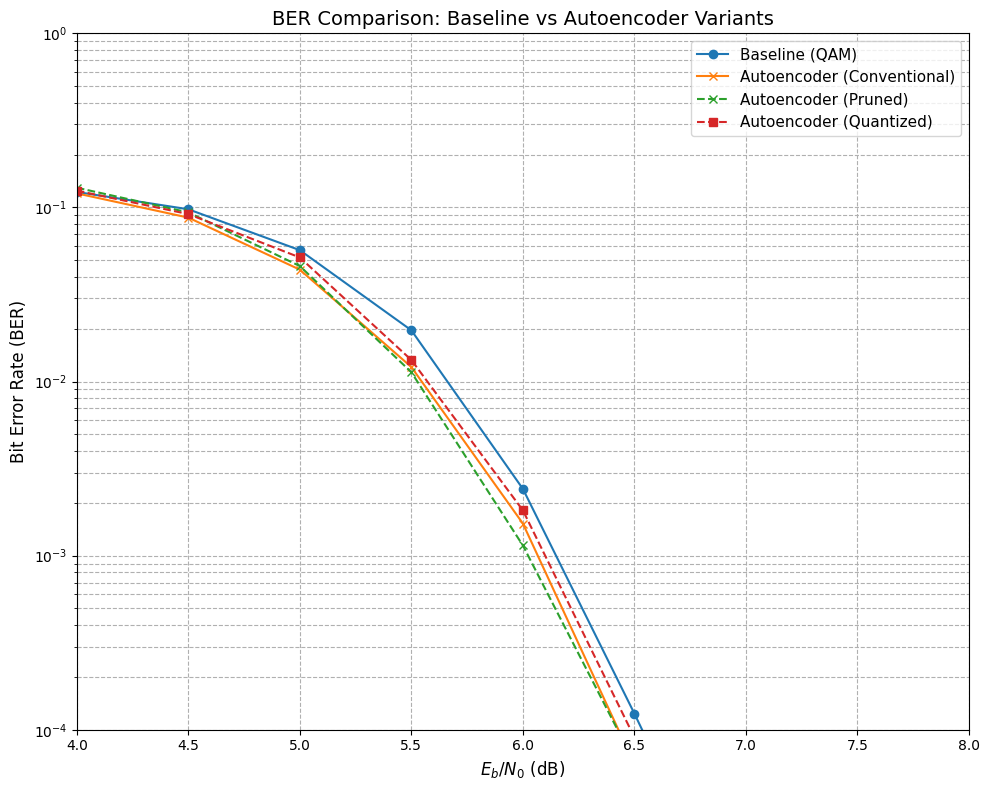

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Baseline (e.g., QAM)
plt.semilogy(ebno_dbs, BER['baseline'], 'o-', color='C0', label='Baseline (QAM)')

# Autoencoder (conventional training)
plt.semilogy(ebno_dbs, BER['autoencoder-conv'], 'x-', color='C1', label='Autoencoder (Conventional)')

# Autoencoder (QAT-trained)
plt.semilogy(ebno_dbs, BER['autoencoder-pruned'], 'x--', color='C2', label='Autoencoder (Pruned)')

# Autoencoder (Post-Training Quantized)
plt.semilogy(ebno_dbs, BER['autoencoder-quantized'], 's--', color='C3', label='Autoencoder (Quantized)')

plt.xlabel(r"$E_b/N_0$ (dB)", fontsize=12)
plt.ylabel("Bit Error Rate (BER)", fontsize=12)
plt.title("BER Comparison: Baseline vs Autoencoder Variants", fontsize=14)
plt.grid(True, which="both", linestyle='--', linewidth=0.8)
plt.ylim((1e-4, 1.0))
plt.xlim((ebno_db_min, ebno_db_max))
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()


In [62]:
print("Quantized model evaluation:")
for layer in model_quantized.layers:
    print(layer.__class__.__name__)


Quantized model evaluation:
DynamicBinarySource
PhaseNoiseGaussian
QuantizedDemapperWrapper


## Visualizing the Learned Constellations

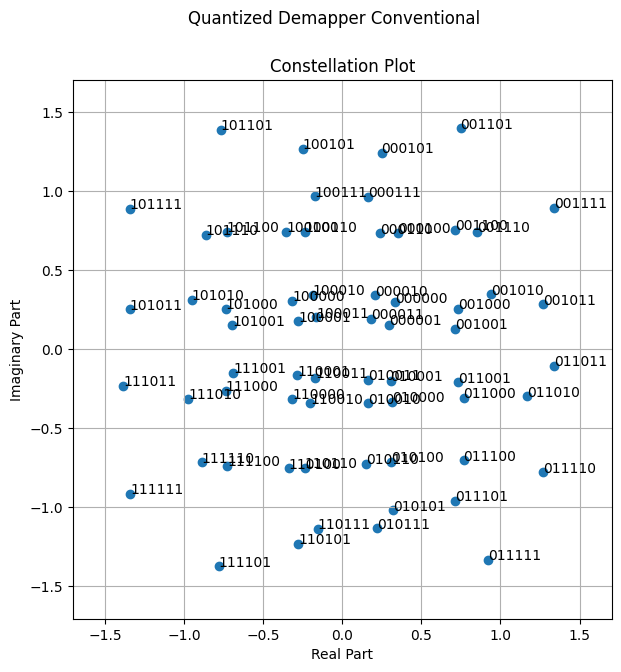

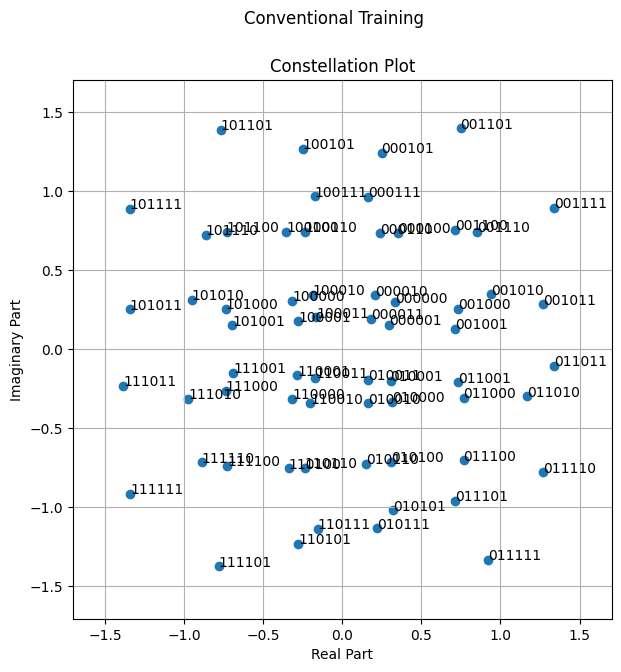

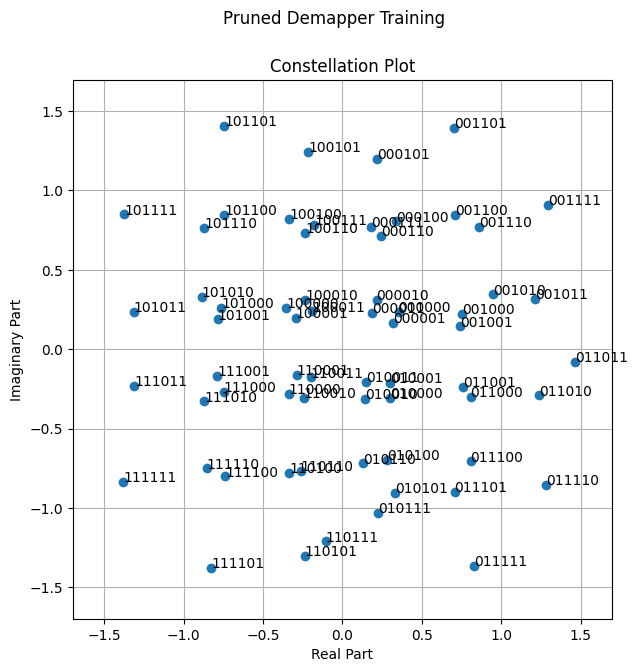

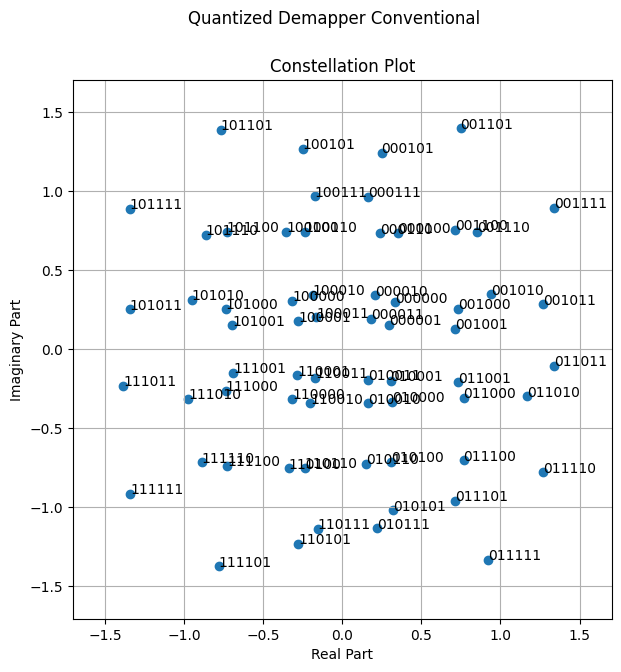

In [63]:
def plot_constellation(model, title):
    points = tf.complex(model.points_r, model.points_i)
    model.constellation.points = points
    fig = model.constellation.show()
    fig.suptitle(title)
    return fig

plot_constellation(model_conventional_eval, "Conventional Training")
plot_constellation(model_pruned_eval, "Pruned Demapper Training")
plot_constellation(model_quantized, "Quantized Demapper Conventional")


In [64]:
# model_conventional = E2ESystemConventionalTraining(training=False)
# load_weights(model_conventional, model_weights_path_conventional_training)
# points = tf.complex(model_conventional.points_r, model_conventional.points_i)
# model_conventional.constellation.points = points  # Ensure constellation object uses trained points
# fig = model_conventional.constellation.show()
# fig.suptitle('Conventional Training');


In [65]:
# model_pruned = E2ESystemConventionalTraining(
#     training=False, use_pruning=True, pruning_params=pruning_params
# )
# load_weights(model_pruned, model_weights_path_conventional_training_pruned)
# points = tf.complex(model_pruned.points_r, model_pruned.points_i)
# model_pruned.constellation.points = points
# fig = model_pruned.constellation.show()
# fig.suptitle('Pruned Demapper Training');


In [66]:
# model_quantized = E2ESystemConventionalTraining(training=False)
# load_weights(model_quantized, model_weights_path_quantized_conventional_training)
# model_quantized._demapper = QuantizedDemapperWrapper("quantized_demapper.tflite")
# points = tf.complex(model_quantized.points_r, model_quantized.points_i)
# model_quantized.constellation.points = points
# fig = model_quantized.constellation.show()
# fig.suptitle('Quantized Demapper Conventional');


## References

[1] T. O’Shea and J. Hoydis, "An Introduction to Deep Learning for the Physical Layer," in IEEE Transactions on Cognitive Communications and Networking, vol. 3, no. 4, pp. 563-575, Dec. 2017, doi: 10.1109/TCCN.2017.2758370.

[2] S. Cammerer, F. Ait Aoudia, S. Dörner, M. Stark, J. Hoydis and S. ten Brink, "Trainable Communication Systems: Concepts and Prototype," in IEEE Transactions on Communications, vol. 68, no. 9, pp. 5489-5503, Sept. 2020, doi: 10.1109/TCOMM.2020.3002915.

[3] F. Ait Aoudia and J. Hoydis, "Model-Free Training of End-to-End Communication Systems," in IEEE Journal on Selected Areas in Communications, vol. 37, no. 11, pp. 2503-2516, Nov. 2019, doi: 10.1109/JSAC.2019.2933891.